In [529]:
from tkinter.tix import InputOnly
import PySimpleGUI as sg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import itertools
from time import sleep
from progress.spinner import MoonSpinner

In [530]:
class Graph(object):
    def __init__(self, vertices):
        self.adjMatrix = []
        for i in range(vertices):
            self.adjMatrix.append([0 for i in range(vertices)])
        self.vertices = vertices

    def addSingleEdge(self, v1, v2):
        if v1 == v2:
            print("Same vertex %d and %d" % (v1, v2))
        else:
            self.adjMatrix[v1][v2] = 1
            self.adjMatrix[v2][v1] = 1
    
    def addEdges(self, probability):
        for node in range(self.vertices):
            if probability == 100: # all edges are connected between each other
                for otherNode in range(self.vertices):
                    self.addSingleEdge(node, otherNode)
            elif getProbability(probability) == True:
                randomNode = random.choice(range(self.vertices))
                self.addSingleEdge(node, randomNode)

    def removeEdge(self, v1, v2):
        global degree
        if self.adjMatrix[v1][v2] == 0:
            print("No edge between %d and %d" % (v1, v2))
            return
        elif v1 == v2:
            print("Same vertex %d and %d" % (v1, v2))
            return
        self.adjMatrix[v1][v2] = 0
        self.adjMatrix[v2][v1] = 0
        degree = degree - 1
    
    def pendantVertices(self):
        pendantVertices = []
        edgesInNodesList = []
        valid, edgesInNodesList = getEdgesPerNodeAndValidate(g.adjMatrix, edgesInNodesList)
        for index, edge in enumerate(edgesInNodesList):
            if edge == 1:
                pendantVertices.append(index)
        return pendantVertices
                
    def removeVertex(self, x):
        global numberOfNodes
        for index, node in enumerate(range(len(str(self.vertices)))):
            if x == node:
                print("Node to delete: " + str(x))
                numberOfNodes = numberOfNodes - 1
                self.adjMatrix.pop(index)
                for i in self.adjMatrix:
                    i.pop(index)

#### Print and draw graph

In [531]:
def printAdjMatrix(graph):
        A = np.array(graph.adjMatrix)
        print(np.matrix(A))

def drawGraph(graph):
        A = np.array(graph.adjMatrix)
        G = nx.from_numpy_matrix(A)
        nx.draw(G, node_color='lightblue', with_labels = 1)

def drawWithColor(param):
    A = np.array(g.adjMatrix)
    G = nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G, seed=3113794652)
    nodeListRed = []
    nodeListBlue = []
    
    for node in range(g.vertices):
        if node == param:
            nodeListRed.append(node)
        else:
            nodeListBlue.append(node)
    
    options = {"edgecolors": "tab:gray", "node_size": 100}
    nx.draw_networkx_nodes(G, pos, nodelist=nodeListRed, node_color="tab:red", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=nodeListBlue, node_color="tab:blue", **options)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

#### Vertex cover

In [532]:
def bruteVertexCover(graph, k, vertex_cover, kernelized):
    spinner = MoonSpinner('Loading ')
    state = "initial"
    
    print("Initial vertex cover in bruteVertexCover: ")
    print(vertex_cover)
    
    if kernelized:
        valid, numOfEdgesPerNode = getEdgesPerNodeAndValidate(graph.adjMatrix, set(vertex_cover))
        # check if initial kernalized set is a vc
        if valid:
            print("Returning the initial and valid vertex cover set")
            print(set(vertex_cover))
            return (set(vertex_cover))
        
        elif graph.vertices == 0:
            print("Retunring valid vertex cover because g.vertices == 0")
            return vertex_cover

        elif k == 0:
            print("Retunring no valid vc because k == 0")
            return None
    else:
        state = "starting brute verex cover"
        
    while state != 'FINISHED':
        for node in range(1, graph.vertices + 1):
            # iterate over k sized subsets and check if each of those subsets is a vertex cover, the subsets are all posible combinations of k size
            for subset in itertools.combinations(range(graph.vertices), node):
                spinner.next()
                # vertex cover iteration of nodes + the current kernalized vertex cover (in case of brute vertex cover is an empty initial vertex cover)
                subset = set(subset)
                vertexCoverSet = set(vertex_cover)
                subset.update(vertexCoverSet)
                valid, numOfEdgesPerNode = getEdgesPerNodeAndValidate(graph.adjMatrix, subset)
                if valid:
                    state = 'FINISHED'
                    print("Returning a valid vertex cover set: ")
                    print(set(subset))
                    return (set(subset))
        
    state = 'FINISHED'
    print("Retunring NONE vc")
    return None

In [533]:
def bvc():
    # input
    numOfVertexCover = int(input())
    initial_vertex_cover = []
    possibleSolutions = bruteVertexCover(g, numOfVertexCover, initial_vertex_cover, False)
    if len(possibleSolutions) <= numOfVertexCover:
        print("Graph has vertex cover at most size: " + str(numOfVertexCover))
    else:
        print("Graph doesn't have vertex cover of size: " + str(numOfVertexCover))

#### Get edges per node and validate vertex cover

In [534]:
def getEdgesPerNodeAndValidate(g, S): 
    isValid = True
    # we create a list of [[0, 0, ...]] (only 1 list inside the list size of the graph adjmatrix)
    numOfEdgesInNode = [0] * len(g)
    # iterate through the adjMatrix
    for i in range(0, len(g)):
        for j in range(i, len(g)): # we start on i because we will be counting the edges twice otherwise
            if g[i][j] == 1: # check if there is an edge between 2 nodes in position [i][j]
                if (i not in S) and (j not in S): 
                    isValid = False
                    numOfEdgesInNode[i] += 1  # example: from 0 we can go to 1
                    numOfEdgesInNode[j] += 1  # example: from 1 we can go to 0
    return isValid, numOfEdgesInNode

#### Probability for adding edge

In [535]:
def getProbability(probability):
        p = float(probability / 100)
        return random.random() < p

#### Make it connected

The graph is connected if from each node, we can visit the rest of the graph by DFS (graph.vertices == count) where count is the number of vertices visted from the initial node.

In [536]:
def DFS(graph, start, visited):
    visited[start] = True
    for node in range(graph.vertices):
        if (graph.adjMatrix[start][node] == 1 and (not visited[node])):
            DFS(graph, node, visited)

def isGraphConnected(graph, start):
    count = 0
    visited = [False] * graph.vertices
    DFS(graph, start, visited)
    for b in visited:
        if (b == True):
            count = count + 1
    if (graph.vertices == count):
        return True
    else:
        return False

def makeItConnected(graph):
    for node in range(graph.vertices):
        nodeConnected = isGraphConnected(graph, node)
        if nodeConnected == True:
            print("Node is connected to the rest of the graph")
        else:
            graph.addSingleEdge(node, random.choice(range(graph.vertices)))
            makeItConnected(graph)

#### - Pendants, selects an arbitrary non-pendant vertex and makes it a pendant by removing arbitrary edges

In [537]:
def lessPendants():
    A = np.array(g.adjMatrix)
    G = nx.from_numpy_matrix(A)

    pendantVerticesList = g.pendantVertices()

    randomNodeToDeleteEdges = random.choice(range(g.vertices))

    while randomNodeToDeleteEdges in pendantVerticesList:
        randomNodeToDeleteEdges = random.choice(range(g.vertices))
        
    global degree 
    degree = G.degree[randomNodeToDeleteEdges]

    print("The node selected to make it pendandn is: " + str(randomNodeToDeleteEdges))

    while degree != 1 and degree > 0:
        randomNode = random.choice(range(g.vertices))
        g.removeEdge(randomNodeToDeleteEdges, randomNode)

    drawWithColor(randomNodeToDeleteEdges)
    #drawGraph(g)

#### + Pendants, selects an arbitrary pendant vertex and makes it non pendant by adding arbitrary edge

In [538]:
def morePendants():
    pendantVerticesList = g.pendantVertices()
    randomNode = random.choice(range(g.vertices))
    randomNodeToAddEdge = random.choice(pendantVerticesList)

    while randomNodeToAddEdge == randomNode:
        randomNodeToAddEdge = random.choice(pendantVerticesList)

    print("The node selected to make not pendandn is: " + str(randomNodeToAddEdge))

    g.addSingleEdge(randomNodeToAddEdge, randomNode)

    drawWithColor(randomNodeToAddEdge)
    #drawGraph(g)

#### - Tops, selects an arbitrary top (vertex with max number of edges) and makes it non top by removing edges

In [539]:
def lessTops():
    A = np.array(g.adjMatrix)
    G = nx.from_numpy_matrix(A)
    
    nodeWithMaxVertices = []
    isValid, numOfEdgesInNode = getEdgesPerNodeAndValidate(g.adjMatrix, nodeWithMaxVertices)
    nodeMax = [x for x in range(0, len(numOfEdgesInNode)) if numOfEdgesInNode[x] == max(numOfEdgesInNode)][0]
    nodeWithMaxVertices.append(nodeMax)
    nodeToRemoveEdges = nodeWithMaxVertices[0]
    print("\nThe node selected to make it non top is: " + str(nodeToRemoveEdges) + "\n")

    global degree 
    degree = G.degree[nodeToRemoveEdges]

    while degree != 1 and degree > 0:
        randomNode = random.choice(range(g.vertices))
        g.removeEdge(nodeToRemoveEdges, randomNode)
        
    drawWithColor(nodeToRemoveEdges)
    #drawGraph(g)

#### + Tops, selects an arbitrary non top (vertex with max number of edges) and makes it top by adding edges


In [540]:
def moreTops():
    nodeWithMaxVertices = []
    isValid, numOfEdgesInNode = getEdgesPerNodeAndValidate(g.adjMatrix, nodeWithMaxVertices)
    nodeMax = [x for x in range(0, len(numOfEdgesInNode)) if numOfEdgesInNode[x] == max(numOfEdgesInNode)][0]
    nodeWithMaxVertices.append(nodeMax)

    randomNode = random.choice(range(g.vertices))
    randomNodeToAddEdge = random.choice(range(g.vertices))

    while (randomNodeToAddEdge == randomNode) and (randomNodeToAddEdge not in nodeWithMaxVertices):
        randomNodeToAddEdge = random.choice(range(g.vertices))

    print("The node selected to make it top is: " + str(randomNodeToAddEdge))

    for otherNode in range(g.vertices):
        g.addSingleEdge(randomNodeToAddEdge, otherNode)

    drawWithColor(randomNodeToAddEdge)
    #drawGraph(g)

#### Finding isolated vertices

In [541]:
def isolatedV():
    isolatedNodes = []
    isValid, numOfEdgesInNode = getEdgesPerNodeAndValidate(g.adjMatrix, [])
    for index, node in enumerate(numOfEdgesInNode):
        if node == 0:
            isolatedNodes.append(index)
    print("The isolated nodes are: " + str(isolatedNodes))
    return isolatedNodes

#### Kernalization

In [542]:
def kernelize(graph, k):
    kernel = graph
    vertex_cover = set()
    reductions_can_be_made = True
    
    A = np.array(graph.adjMatrix)
    G = nx.from_numpy_matrix(A)
    
    isolatedVertices = isolatedV()
    
    while reductions_can_be_made:
        reduction_made = False
        for node in range(kernel.vertices):
            degree = G.degree[node]
            # If k>0 and v is a vertex of degree greater than k, remove v from the graph and decrease k by one
            if k > 0 and degree > k:
                print("Degree of node " + str(node) + " is : " + str(degree) + " and is bigger than 0 and current k.")
                reduction_made = True
                kernel.removeVertex(node)
                print("Deleting node from Ad Matrix and adding it to vertex cover " + str(node))
                vertex_cover.add(node)
                print("Current vc: ")
                print(vertex_cover)
                k = k - 1
                print("Current value of k -> k - 1 = " + str(k))
            # removing isolated vertices
            elif node in isolatedVertices:
                kernel.removeVertex(node)

        if not reduction_made:
            reductions_can_be_made = False
            
    print("Vertex cover at the end of kernalize: ")
    print(vertex_cover)
    return kernel, vertex_cover

def vertex_cover_kernelization(graph, k):
    print("Initial k: " + str(k))
    kernel, vertex_cover = kernelize(graph, k)
    print("Updated k at the end of kernalize: " + str(k))
    # If more than k^2 edges remain in the graph, and neither of the previous two rules can be applied, then the graph cannot contain a vertex cover of size k
    print("Is kernel.vertices: " + str(kernel.vertices) + " is > than k^2 = " + str(k ** 2) + " ?")
    if kernel.vertices > k ** 2:
        print("Retunring NONE vc because k^2 edges remain in the graph.")
        return None
    return bruteVertexCover(kernel, k, vertex_cover, True)

def kvc():
    # input
    numKVertexCover = int(input())
    possibleSolutions = vertex_cover_kernelization(g, numKVertexCover)
    if possibleSolutions == None:
        print("Graph doesn't have vertex cover of size: " + str(numKVertexCover))
    else:
        print("Graph has vertex cover of at most size: " + str(numKVertexCover))
        print("Nodes in vertex cover: ")
        print(possibleSolutions)

#### Search tree

In [543]:
class Node:
    def __init__(self, key, left = None, right = None):
        self.key = key
        self.left = left
        self.right = right

# ADJ Matrix to binary tree
def constructTree(mat):
    if not mat:
        return None
 
    N = len(mat)
    d = {}
   
    for i in range(N):
        total = sum(mat[i])
        d.setdefault(total, []).append(i)
 
    node = [Node(-1)] * N
    last = 0
    parent = [False] * N
 
    # Traverse the dictionary in sorted order
    for key in sorted(d.keys()):
        for row in d.get(key):
            last = row
            node[row] = Node(row)
            
            # leaf
            if key == 0:
                continue
 
            for i in range(N):
                if not parent[i] and mat[row][i] == 1:
                    if node[row].left is None:
                        node[row].left = node[i]
                    else:
                        node[row].right = node[i]
                    parent[i] = True
                    
    # last processed node is the root
    return node[last]

# Vertex Cover using tree
def vCover(root):
    if (root == None):
        return 0
         
    if (root.left == None and
       root.right == None):
        return 0
 
    # Calculate size of vertex cover when root is part of it
    size_incl = (1 + vCover(root.left) +
                     vCover(root.right))
    # Calculate size of vertex cover when root is not part of it
    size_excl = 0
    if (root.left):
      size_excl += (1 + vCover(root.left.left) +
                        vCover(root.left.right))
    if (root.right):
      size_excl += (1 + vCover(root.right.left) +
                        vCover(root.right.right))
 
    return min(size_incl, size_excl)

def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '-> ' + str(node.key))
        printTree(node.right, level + 1)

#### Global variables

In [544]:
numberOfNodes: int
probability: int
g: Graph

In [545]:
# input
numberOfNodes = int(input())
probability = int(input())

# Draw graph

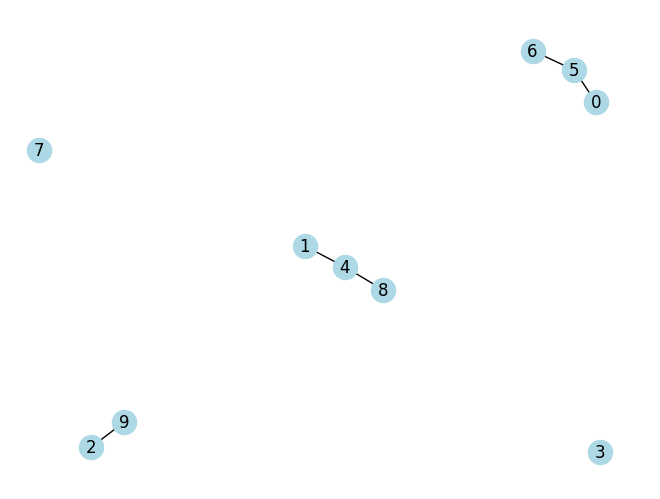

In [546]:
g = Graph(numberOfNodes)
g.addEdges(probability)
drawGraph(g)

# Make it connected

Same vertex 0 and 0
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of the graph
Node is connected to the rest of t

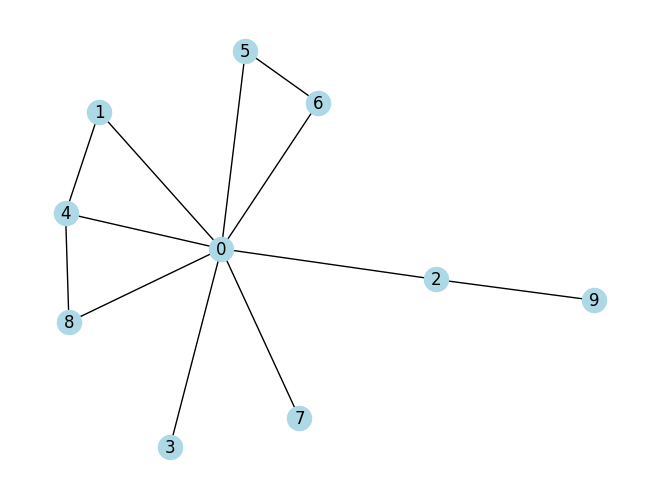

In [547]:
makeItConnected(g)
drawGraph(g)

# Brute vertex cover

In [548]:
bvc()

Initial vertex cover in bruteVertexCover: 
[]
Returning a valid vertex cover set: 
{0, 2, 4, 5}
Graph has vertex cover at most size: 5


# Pendants

The node selected to make it pendandn is: 6
No edge between 6 and 4


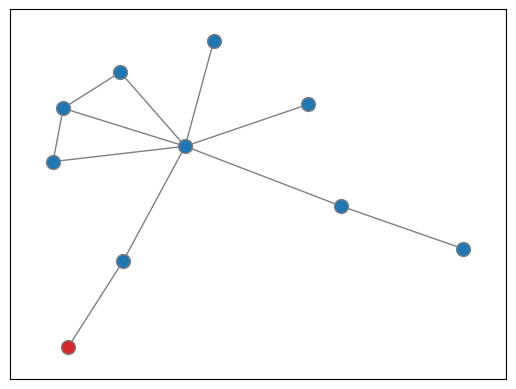

In [549]:
lessPendants()

The node selected to make not pendandn is: 7


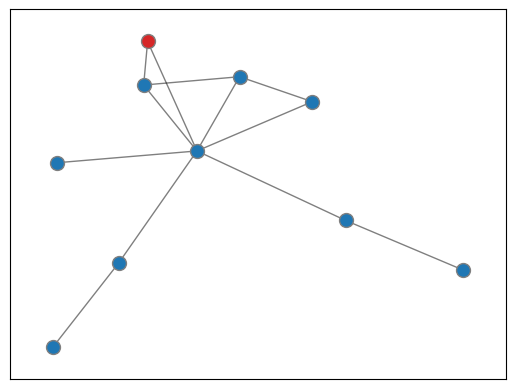

In [550]:
morePendants()

# Tops and isolated vertices


The node selected to make it non top is: 0

No edge between 0 and 4
No edge between 0 and 4
No edge between 0 and 0
No edge between 0 and 9
No edge between 0 and 2
No edge between 0 and 0
No edge between 0 and 2
No edge between 0 and 9
No edge between 0 and 8
No edge between 0 and 8
No edge between 0 and 2


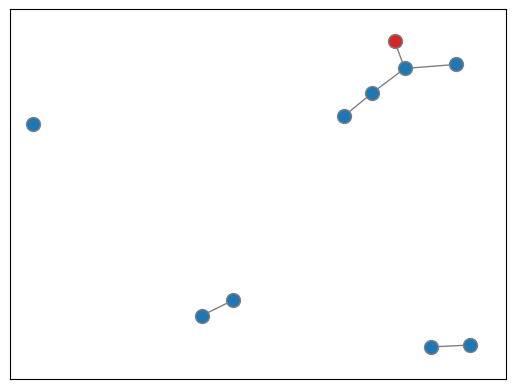

In [551]:
lessTops()

In [552]:
isolatedVertices = isolatedV()
isolatedVertices

The isolated nodes are: [3]


[3]

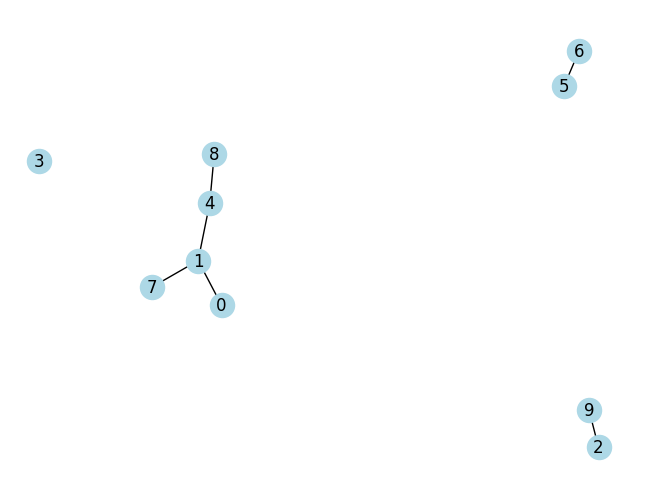

In [553]:
drawGraph(g)

The node selected to make it top is: 4
Same vertex 4 and 4


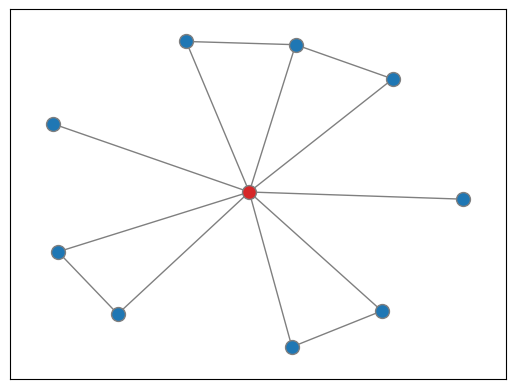

In [554]:
moreTops()

# Kernelization

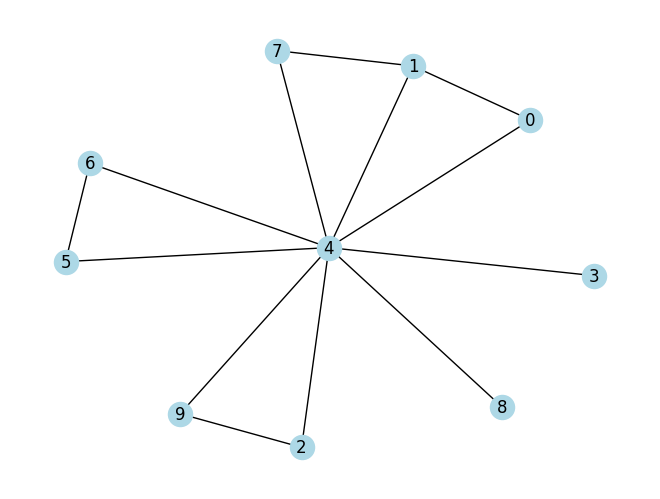

In [555]:
drawGraph(g)

In [556]:
kvc()

Initial k: 5
The isolated nodes are: []
Degree of node 4 is : 9 and is bigger than 0 and current k.
Deleting node from Ad Matrix and adding it to vertex cover 4
Current vc: 
{4}
Current value of k -> k - 1 = 4
Degree of node 4 is : 9 and is bigger than 0 and current k.
Deleting node from Ad Matrix and adding it to vertex cover 4
Current vc: 
{4}
Current value of k -> k - 1 = 3
Degree of node 4 is : 9 and is bigger than 0 and current k.
Deleting node from Ad Matrix and adding it to vertex cover 4
Current vc: 
{4}
Current value of k -> k - 1 = 2
Degree of node 1 is : 3 and is bigger than 0 and current k.
Node to delete: 1
Deleting node from Ad Matrix and adding it to vertex cover 1
Current vc: 
{1, 4}
Current value of k -> k - 1 = 1
Degree of node 2 is : 2 and is bigger than 0 and current k.
Deleting node from Ad Matrix and adding it to vertex cover 2
Current vc: 
{1, 2, 4}
Current value of k -> k - 1 = 0
Vertex cover at the end of kernalize: 
{1, 2, 4}
Updated k at the end of kernalize:

#### Tree

In [557]:
root = constructTree(g.adjMatrix)
printTree(root)

        -> -1
    -> 0
-> 3
    -> 7


In [558]:
print("Size of the smallest vertex cover using binary tree is", vCover(root))

Size of the smallest vertex cover using binary tree is 2
